In [1]:
#!pip --no-cache-dir install --user -I dash==1.4.1 dash-core-components==1.3.1 dash-html-components==1.0.1 dash-cytoscape==0.2.0
#!pip install dash-bootstrap-components

In [2]:
import numpy as np
import pandas as pd
import dash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import dash_table
import json
import dash_cytoscape as cyto


In [3]:
# app = dash.Dash(__name__)
app = dash.Dash(external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server

app.scripts.config.serve_locally = True
app.css.config.serve_locally = True
app.config.assets_external_path = ""    # The external prefix if serve_locally == False


In [4]:
_MAX_DEPTH = 10

In [5]:
%matplotlib inline
pd.options.display.precision = 10
pd.set_option('display.max_columns', 1000)

In [6]:
# サンプルデータによる決定木
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

feature_names = cancer.feature_names
class_names = cancer.target_names

from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=_MAX_DEPTH)
clf = clf.fit(cancer.data, cancer.target)



### Scikitlearnデフォルトの描画

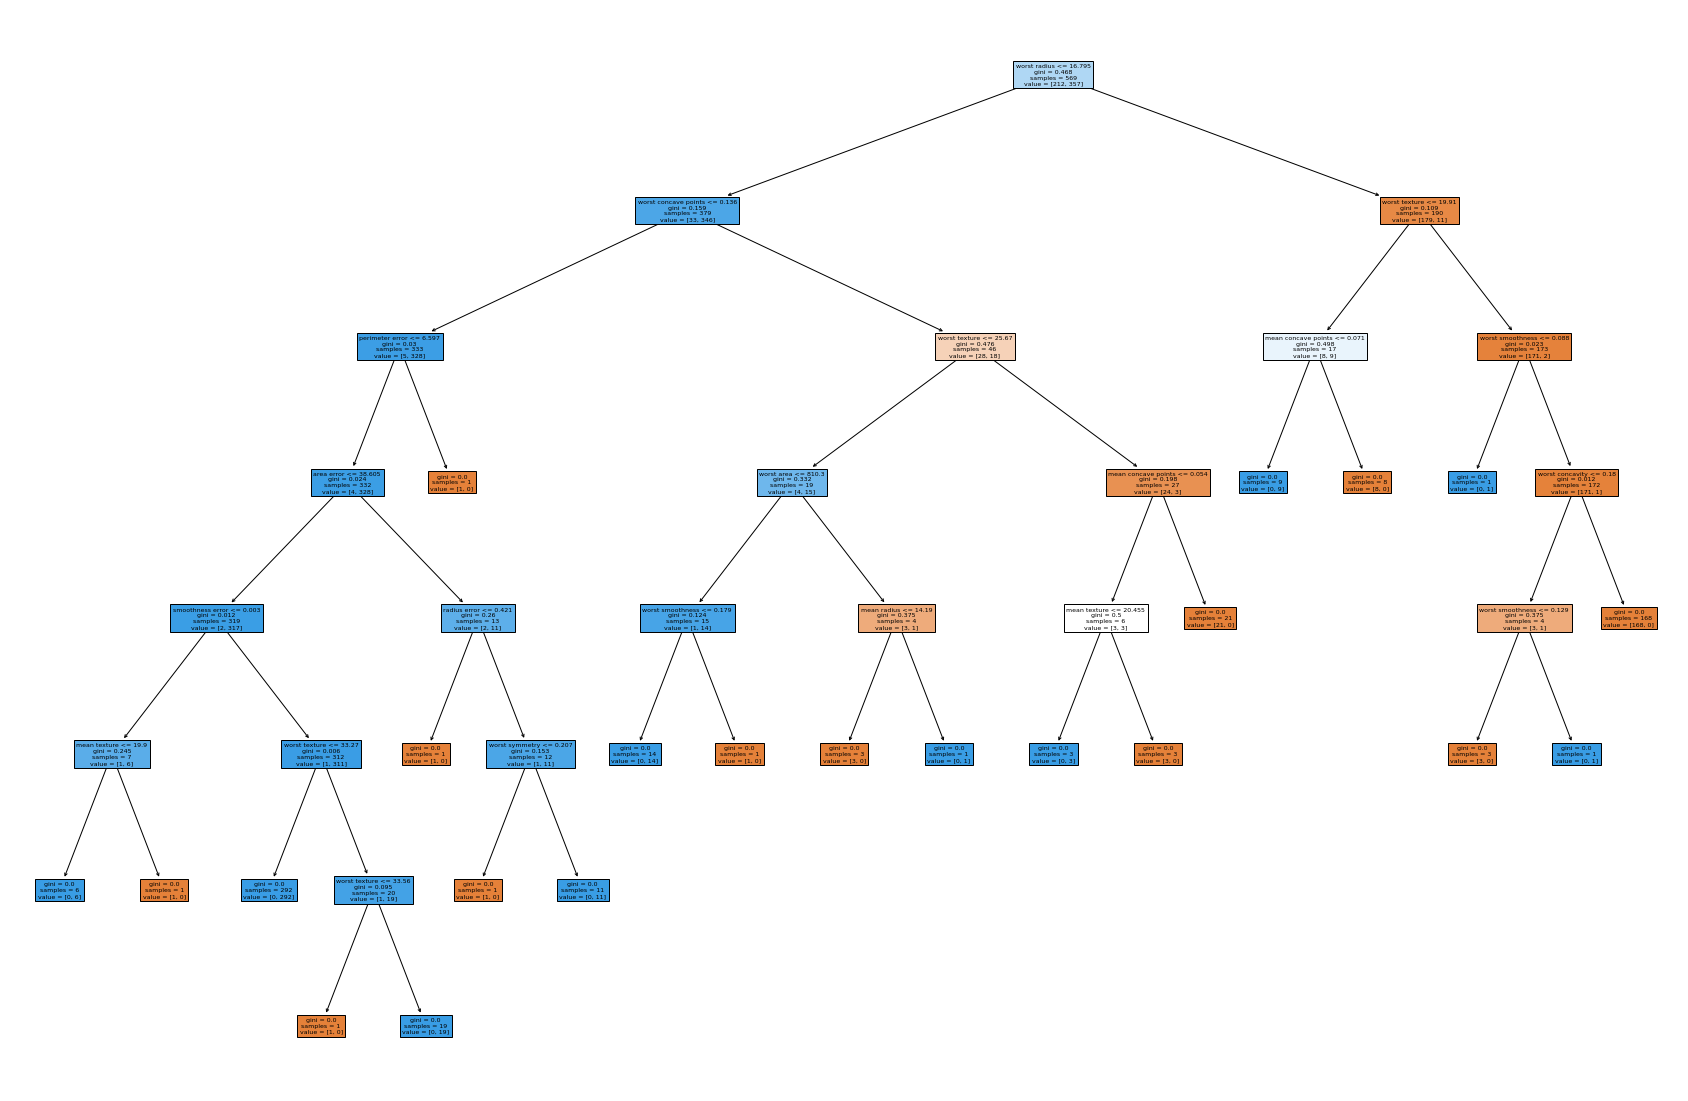

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))
tree.plot_tree(clf, feature_names=feature_names, filled=True)
plt.show()

In [8]:
# 決定木構造情報の抽出
n_nodes = clf.tree_.node_count # ノードの数（int）
children_left = clf.tree_.children_left # 各ノードから左（True, 閾値以下）への分岐先ノード番号（list）
children_right = clf.tree_.children_right # 各ノードから右（False, 閾値超）への分岐先ノード番号（list）
feature = clf.tree_.feature # 各ノードの分岐に使用される変数の番号（list）
threshold = clf.tree_.threshold # 分岐の閾値（list）
value = clf.tree_.value # ノードの値
impurity = clf.tree_.impurity # ノードの不順ド
n_node_samples = clf.tree_.n_node_samples # ノードのサンプル数

In [9]:
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)

In [10]:
max(node_depth)

0

In [11]:
# 各ノードがリーフかどうかの判定
stack = [(0, -1)]  
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

In [12]:

cy_edges = []
cy_nodes = []
nodes_conditions = [[] for _ in range(n_nodes)]

for i in range(n_nodes):
    
    if is_leaves[i]:
        cls_name = "node leaf"
    else:
        cls_name = "node inner"
        
    num_positive = int(value[i][0][1])
    num_negative = int(value[i][0][0])
    ratio_positive = num_positive/n_node_samples[i]
    ratio_negative = num_negative/n_node_samples[i]
    samples_ratio = n_node_samples[i]/n_node_samples[0]
    
    left_ratio = n_node_samples[children_left[i]]/n_node_samples[i]
    weight_left = left_ratio*5 if left_ratio*5 > 1 else 1
    right_ratio = n_node_samples[children_right[i]]/n_node_samples[i]
    weight_right = right_ratio*5 if right_ratio*5 > 1 else 1
    
    if children_left[i] != -1:

        condition_left = str(feature_names[feature[i]]) + " <= " + str(round(threshold[i], 3))
        #nodes_conditions[children_left[i]] = nodes_conditions[i] + condition_left
        nodes_conditions[children_left[i]].extend(nodes_conditions[i])
        nodes_conditions[children_left[i]].append(condition_left)
        
        cy_edges.append({
            "data":{
                "id": str(i) + "-" + str(children_left[i]),
                "label": str(feature_names[feature[i]]) + " <= " + str(round(threshold[i], 3)),
                "source": str(i),
                "target": str(children_left[i]),
                "weight": weight_left,    
                "feature": feature_names[feature[i]],
                "threshold": threshold[i],  
            },
            "classes": "edge left",
                       
        })
        
    if children_right[i] != -1:
        
        condition_right =  str(feature_names[feature[i]]) + " > " + str(round(threshold[i], 3))
        nodes_conditions[children_right[i]].extend(nodes_conditions[i])
        nodes_conditions[children_right[i]].append(condition_right)

        cy_edges.append({
            "data":{
                "id": str(i) + "-" + str(children_right[i]),
                "label": str(feature_names[feature[i]]) + " > " + str(round(threshold[i], 3)),
                "source": str(i),
                "target": str(children_right[i]),
                "weight": weight_right,
                "feature": feature_names[feature[i]],
                "threshold": threshold[i],     
            },
            "classes": "edgeright",
                   
        })
    cy_nodes.append({
        "data": {
            "id": str(i),
            "label":  "samples： {} ({}%)\npositives： {} ({}%)".format(n_node_samples[i], int(samples_ratio*100), num_positive, int(ratio_positive*100)),
            "samples_ratio": samples_ratio,
            "impurity": impurity[i],
            "depth": node_depth[i],
            "value": value[i][0],
            "positive_ratio": ratio_positive,
            "negative_ratio": ratio_negative,
            "conditions": nodes_conditions[i],
        },
        "classes": cls_name,
        "selected": False,
        "grabbable": True,
        
    })
        
        

In [13]:
all_elements = cy_edges + cy_nodes

In [14]:
# スタイルシート
default_stylesheet = [
    {
        "selector": 'node', # for all nodes
        'style': {
            "width": 120,
            "height": 120, #80,
            "opacity": 0.9,
            "label": "data(value)", 
            "background-color": "#C5D3E2", # nodeの色
            "color": "#444444", # nodeのラベルの色
            'font-size': 14,
            'text-wrap': "wrap",
            'min-zoomed-font-size': 4,
            "content": "data(label)",
            #"text-valign": "center",
            #"text-halign": "center",          
            'pie-size': '93%',
            'pie-1-background-color': '#34495e',
            'pie-1-background-size': 'mapData(positive_ratio, 0, 1, 0, 100)',    # mapData(weight,0,100,blue,red) は、要素の重みを、0 から 100 までの重みの青と赤の間のグラデーションにマップ
            'pie-2-background-color': '#3498db',
            'pie-2-background-size': 'mapData(negative_ratio, 0, 1, 0, 100)',
    }
    },
     {
        'selector': ':selected',
        'style': {
            'color': '#34495e',
            "background-color": "#888888",
            'opacity': 1,
        }
    },
    {
        "selector": 'edge', # for all edges
        "style": {
            "target-arrow-color": "#C5D3E2", #"#95a5a6" # 矢印の色
            "target-arrow-shape": "triangle", # 矢印の形
            #"mid-target-arrow-color": "#C5D3E2",
            #"mid-target-arrow-shape": "triangle",
            "line-color": "#C5D3E2",#"#95a5a6",  # edgeのcolor
            'arrow-scale': 1.5, # 矢印のサイズ
            'curve-style': 'unbundled-bezier', # 矢印の表示
            "control-point-distances": [20],
            "control-point-weights": [0.5],
            'content': "data(weight)",
            'color': "#888888",
            'font-size': 14,
            'min-zoomed-font-size': 4,
            'width': "data(weight)", #1,
            'label': "data(label)",
        }
    
    }
]

In [15]:
default_layout = {
            'name': 'cose',
            'idealEdgeLength': 100,
            'nodeOverlap': 20,
            'refresh': 20,
            'fit': True,
            'padding': 30,
            'randomize': False,
            'componentSpacing': 100,
            'nodeRepulsion': 4000,
            'edgeElasticity': 100,
            'nestingFactor': 5,
            'gravity': 80,
            'numIter': 1000,
            'initialTemp': 200,
            'coolingFactor': 0.95,
            'minTemp': 1.0,
            #'animationThreshold': 2500,
            'animate': True,
            'animationDuration': 1000,
        }

default_layout = {
    "name": "breadthfirst",
    "roots": "#0",
    "circle": False
}

In [16]:
# HTMLレイアウト
app.layout = html.Div([
    
    html.Div(children=[
        cyto.Cytoscape(
            id='cytoscape',
            elements=all_elements,
            style={
                'height': '95vh',
                'width': '100%',
                'float': "left",
            },
            stylesheet= default_stylesheet,
            layout= default_layout,
            autoRefreshLayout=True,
            minZoom=0.1,
            responsive=True,
            )],
             id = "cyto-space"
        )
    ])

In [17]:
# Bootstrap

controls = dbc.Card(
    [
        dbc.FormGroup(
            [
                dbc.Label("max depth"),
                dcc.Slider(
                    id="max_depth-slider",
                    min = 1,
                    max = max(node_depth),
                    step = 1,
                    value = max(node_depth),
                    tooltip={
                        "always_visible": False,
                        "placement": "bottom"
                    },
                    updatemode="drag",
                ),
            ]
        ),
         dbc.FormGroup(
            [
                dbc.Label("min. samples (%)"),
                dcc.Slider(
                    id="samples-slider",
                    min = 0,
                    max = 100,
                    step = 5,
                    value = 0,
                    tooltip={
                        "always_visible": True,
                        "placement": "bottom"
                    },
                    updatemode="drag",
                ),
            ]
        ),
         dbc.FormGroup(
            [
                dbc.Label("min. positives (%)"),
                dcc.Slider(
                    id="positives-slider",
                    min = 0,
                    max = 100,
                    step = 5,
                    value = 0,
                    tooltip={
                        "always_visible": True,
                        "placement": "bottom"
                    },
                    updatemode="drag",
                ),
            ]
        ),
    ],
    body=True,
)

info = dbc.Card([
    dbc.Label("selected node"),
    html.Div(children=[
            html.Pre(
                id='selected-node-data',
                style={}
            ),
        ],
        style={}
        )
    ], body=True)


app.layout = dbc.Container([
    dbc.Row(
            [
                dbc.Col(
                    html.H4(""),
                    style={
                        "background-color": "#fff",
                        "color": "#34495e",
                    }
                    )
            ],
            #className="h-12"
        ),
    dbc.Row([
        dbc.Col([
                     html.P(""),
                     html.Div(children=[
                                    cyto.Cytoscape(
                                        id='cytoscape',
                                        elements=all_elements,
                                        style={
                                            'height': '95vh',
                                            'width': '100%',
                                            'float': "left",
                                        },
                                        stylesheet= default_stylesheet,
                                        layout= default_layout,
                                        autoRefreshLayout=True,
                                        minZoom=0.1,
                                        responsive=True,
                                )],
                                id = "cyto-space"
                        )],
                    md = 9,
                    style = {
                        "height": "100%",
                        "background-color": "white",
                        "border-color": "white",
                        "border-width":"10px"
                        },
        ),
        dbc.Col([controls, info], md=3
        )
    ])
],
style = {
    "max-width": "100%"
})

In [18]:
@app.callback(Output('cytoscape', 'elements'),
                           [Input('max_depth-slider', 'value')])
def regenerate_nodes(mdepth):
    new_elements = []
    rmv_node_id = []
    for node in cy_nodes:
        if node["data"]["depth"] > mdepth:
            node_id = node["data"]["id"] 
            rmv_node_id.append(node_id)
        else:
            new_elements.append(node)
    
    for edge in cy_edges:
        if edge["data"]["source"] not in rmv_node_id and edge["data"]["target"] not in rmv_node_id:
            new_elements.append(edge)
    
    return new_elements

@app.callback(Output('cytoscape', 'stylesheet'),
               [Input('samples-slider', 'value'),
                Input('positives-slider', 'value')])
def update_cytoscape_style(min_samples, min_pos ):
    min_samples = min_samples/100
    min_pos = min_pos/100
    
    new_style = [{
        "selector": f"[samples_ratio < {min_samples}]",
        "style": {
            "color": "#bdc3c7", 
            'pie-1-background-color': '#bdc3c7',
            'pie-2-background-color': '#ecf0f1',
        }
    },{
        "selector": f"[positive_ratio < {min_pos}]",
        "style": {
            "color": "#bdc3c7", 
            'pie-1-background-color': '#bdc3c7',
            'pie-2-background-color': '#ecf0f1',
        }
    }]
    new_stylesheet = default_stylesheet + new_style
    
    
    return new_stylesheet

@app.callback(Output('selected-node-data', 'children'),
              [Input('cytoscape', 'tapNode')])
def displayTapNode(data):
    if data is not None:
        cond = "\n".join(data["data"]["conditions"])
        label = data["data"]["label"]
        imp = "impurity: {}\n".format(round(data["data"]["impurity"], 3))
        
        return "\n".join([label, imp, cond])
    else:
        return ""

In [19]:
app.run_server(host='127.0.0.1', port=8050, debug=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [14/Jun/2021 14:12:19] "GET /_reload-hash HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:19] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:19] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:19] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:21] "GET /_reload-hash HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:23] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:23] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun/2021 14:12:23] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Jun